# Parcial 2
Juan Esteban Gonzalez y Leonardo Luengas

## Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install opencv-python
import cv2
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
import os
import shutil
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc, f1_score, make_scorer
from scipy.stats import mode

## Traer el Dataset

Utilizamos un Dataset traído de Kaggle que contiene dos carpetas. Una tiene imágenes de calles sin huecos desde distintos ángulos y la otra tiene calles con huecos de distintas formas y tamaños.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juangonzalez03","key":"19e4f3e9c89e8b8ca6487097f0583744"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle datasets download -d atulyakumar98/pothole-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/atulyakumar98/pothole-detection-dataset
License(s): CC0-1.0


In [4]:
!unzip pothole-detection-dataset.zip -d pothole > /dev/null

In [5]:
# Directorios base
base_dir = '/content/pothole'
output_dir = os.path.join(base_dir, 'imagenes_RAW')

# Crear carpeta de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Subcarpetas a procesar
subcarpetas = ['normal', 'potholes']

for sub in subcarpetas:
    sub_dir = os.path.join(base_dir, sub)
    for archivo in os.listdir(sub_dir):
        origen = os.path.join(sub_dir, archivo)
        if os.path.isfile(origen):
            nombre, ext = os.path.splitext(archivo)
            nuevo_nombre = f"{nombre}-{sub}{ext}"
            destino = os.path.join(output_dir, nuevo_nombre)
            shutil.copy2(origen, destino)

print("Imágenes copiadas y renombradas correctamente.")

Imágenes copiadas y renombradas correctamente.


## Pipeline Preprocesamiento

Implementamos 4 tipos de transformaciones para el pipeline de preprocesamiento: transformación a escala de grises, aplicación del filtro de Canny, aplicación de un blur Gaussiano y una reducción de resolución de las imágenes.

## Preprocesamiento de Imágenes: Filtro Gaussiano y Detección de Bordes de Canny

En el procesamiento digital de imágenes, es común aplicar técnicas de preprocesamiento para mejorar la calidad de las imágenes y facilitar tareas posteriores como la detección de bordes o la segmentación. A continuación, se describen dos técnicas fundamentales: el suavizado gaussiano y la detección de bordes mediante el algoritmo de Canny.


### Suavizado Gaussiano (`GaussianBlur`)

El filtro gaussiano permite reducir el ruido presente en una imagen mediante la convolución con una función gaussiana bidimensional, definida como:

$$
G(x, y) = \frac{1}{2\pi\sigma^2} \exp\left( -\frac{x^2 + y^2}{2\sigma^2} \right)
$$

Donde:
- $(x, y)$ son las coordenadas en el vecindario del píxel.
- $\sigma$ es la desviación estándar del filtro, que controla el grado de suavizado.

La imagen suavizada $I'$ se obtiene aplicando una convolución con el kernel $G$:

$$
I'(i, j) = \sum_{x=-k}^{k} \sum_{y=-k}^{k} I(i+x, j+y) \cdot G(x, y)
$$

El suavizado gaussiano reduce las variaciones locales abruptas en la intensidad, lo cual es útil para mejorar la precisión en la detección de bordes.


### Detección de Bordes de Canny (`ApplyCanny`)

El algoritmo de Canny es un método robusto y multietapa para la detección de bordes. Sus pasos principales son los siguientes:

#### 2.1 Cálculo del Gradiente

Se aplican operadores de Sobel para obtener las derivadas en las direcciones $x$ e $y$:

$$
G_x = \begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}, \quad
G_y = \begin{bmatrix} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{bmatrix}
$$

La magnitud y dirección del gradiente se calculan como:

$$
M(i,j) = \sqrt{I_x(i,j)^2 + I_y(i,j)^2}
$$

$$
\theta(i,j) = \arctan\left( \frac{I_y(i,j)}{I_x(i,j)} \right)
$$

#### 2.2 Supresión de No-Máximos (*Non-Maximum Suppression*)

Este paso afina los bordes eliminando aquellos píxeles cuya magnitud no sea un máximo local en la dirección del gradiente.

#### 2.3 Umbralización con Histeresis

La **histeresis** es un mecanismo de decisión empleado en la última etapa del algoritmo de Canny para identificar los píxeles que forman parte de un borde real. Se basa en la aplicación de **dos umbrales**: uno alto ($T_{high}$) y uno bajo ($T_{low}$), en lugar de un único umbral fijo.

Este procedimiento mejora la detección de bordes débiles que están conectados a bordes fuertes, reduciendo al mismo tiempo los falsos positivos producidos por ruido.

#### Procedimiento

Dado un mapa de magnitud de gradiente $M(i,j)$, los píxeles se clasifican de la siguiente manera:

- **Bordes fuertes**: si $M(i,j) > T_{high}$  
  → Se consideran parte del borde y se conservan.

- **No bordes**: si $M(i,j) < T_{low}$  
  → Se eliminan.

- **Bordes débiles**: si $T_{low} \leq M(i,j) \leq T_{high}$  
  → Se conservan **solo si están conectados** (por vecindad de 8 conectados) a un borde fuerte.

#### Justificación

El uso de dos umbrales permite equilibrar sensibilidad y precisión:

- $T_{high}$ garantiza que solo los bordes con fuerte respuesta se acepten directamente.
- $T_{low}$ permite que bordes con respuesta más débil sean considerados válidos si están cerca de uno fuerte.

Este enfoque mejora la **continuidad de los bordes** sin introducir ruido espurio.



In [6]:
class ToGrayscale(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self
  def transform(self, X):
        #Recibe una lista de imágenes en X y las pasa a blanco y negro
        return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in X]

class ApplyCanny(BaseEstimator, TransformerMixin):
  def fit(self, X, y =None):
    return self
  def transform(self, X):
    #Recibe una lista de imágenes y les aplica el filtro de Canny para encontrar bordes
    p = []
    for img in X:
      #Aplica el filtro de Canny
      img_p = cv2.Canny(img, 110,200)
      p.append(img_p)
    return p

class GaussianBlur(BaseEstimator, TransformerMixin):
  def fit(self, X, y = None):
    return self
  def transform(self, X):
    p = []
    for img in X:
      #Primero aplica un filtro Gaussiano para reducir el ruido (La calle tiene una textura con muchos artefactos)
      img_b = cv2.GaussianBlur(img, (5,5), sigmaX = 1)
      p.append(img_b)
    return p

class DownScale(BaseEstimator,TransformerMixin):
  def fit(self, X, y = None):
    return self
  def transform(self, X):
    p = []
    for img in X:
      if img is not None:
        img_b = cv2.resize(img, (512, 512))  # Resize to 512x512
        p.append(img_b)
    return p

Definimos que para las imágenes con un label de 0 significa que no tiene huecos. Cuando tiene un label de 1 significa que la imágen presenta huecos.

In [7]:
#Build dataset
X = []
truth_labels = []
path = "./pothole/imagenes_RAW"
for pth in os.listdir(path):
  img = cv2.imread(f"{path}/{pth}")
  L = 0 if "normal" in pth else 1
  if img is None:
    continue
  X.append(img)
  truth_labels.append(L)
print(f"Tamaño del dataset {len(X)}")

Tamaño del dataset 680


Escogemos tres imágenes aleatorias para mostrar que tipo de imágenes están en el dataset.

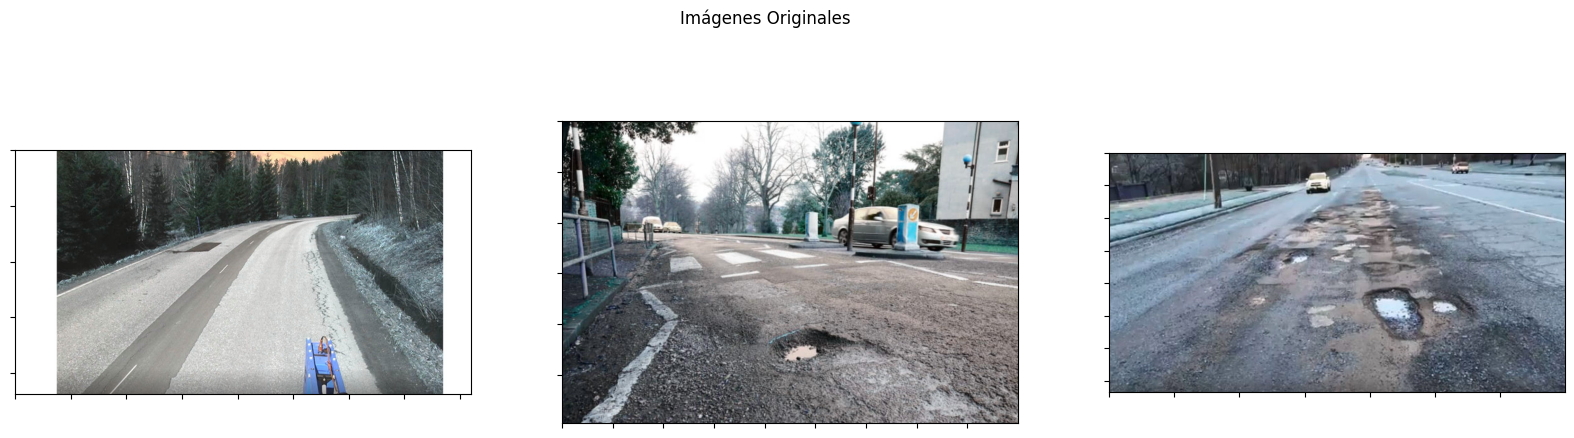

In [8]:
#Display some images
fig, axs = plt.subplots(1,3, gridspec_kw={'width_ratios': [1,1,1]})
fig.set_size_inches(20,15)
fig.suptitle("Imágenes Originales")
plt.subplots_adjust(top=1.5)

choice = np.random.choice(len(os.listdir(path)), 3)
for c,i in enumerate(choice):
  img = cv2.imread(f"{path}/{os.listdir(path)[i]}")
  axs[c].imshow(img)

  axs[c].set_yticklabels([])
  axs[c].set_xticklabels([])

plt.show()

In [9]:
preprocesamiento = Pipeline([
    ("resize", DownScale()),
    ("gray", ToGrayscale()),
    ("blur", GaussianBlur()),
    ("canny", ApplyCanny()),
])

p_images = preprocesamiento.fit_transform(X)

Visualizamos las mismas tres imágenes después del preprocesamiento para ver como es el resultado del procesamiento.

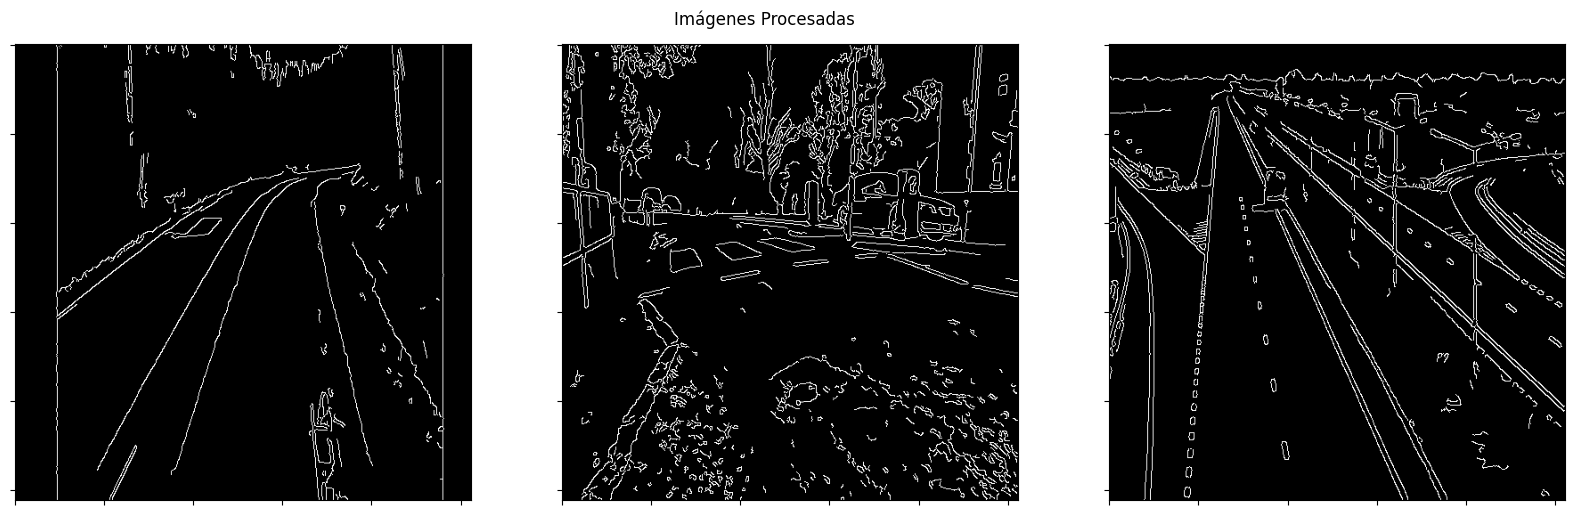

In [10]:
fig, axs = plt.subplots(1,3, gridspec_kw={'width_ratios': [1,1,1]})
fig.set_size_inches(20,15)
fig.suptitle("Imágenes Procesadas")
#fig.tight_layout()
plt.subplots_adjust(top=1.5)
for c,i in enumerate(choice):
  axs[c].imshow(p_images[i], cmap = "gray")
  axs[c].set_yticklabels([])
  axs[c].set_xticklabels([])
plt.show()

## Pipeline Feature Detection y BoVW

### Extracción de Características con SIFT y Representación con Bag of Visual Words (BoVW)

En tareas de clasificación y reconocimiento de imágenes, una etapa clave consiste en extraer descriptores que representen el contenido visual de forma robusta y discriminativa. A continuación, se describen dos técnicas complementarias: el algoritmo **SIFT** para extracción de características locales y el modelo **BoVW** como representación global basada en histogramas de ocurrencia.

### 1. SIFT: Scale-Invariant Feature Transform

El algoritmo **SIFT** (propuesto por David Lowe en 2004) detecta y describe **puntos de interés locales** en una imagen, siendo robusto a transformaciones de escala, rotación, y parcialmente a iluminación y cambios de perspectiva.

#### Etapas principales del algoritmo SIFT

1. **Detección de extremos en espacio de escala**  
   Se construye una **pirámide de escalas** a partir de imágenes suavizadas con filtros gaussianos de diferentes $\sigma$, y se calcula la **Diferencia de Gaussianas (DoG)** para detectar extremos (mínimos y máximos locales) en una vecindad 3D $(x, y, \sigma)$.

2. **Localización precisa de los puntos clave**  
   Se ajusta una función cuadrática a los extremos detectados para refinar su posición y eliminar aquellos con bajo contraste o alineados a bordes.

3. **Asignación de orientación**  
   Se calcula el gradiente local en una vecindad alrededor del punto clave. A cada punto se le asigna una orientación dominante $\theta$, lo que garantiza **invariancia rotacional**.

4. **Cálculo del descriptor**  
   Se construye un descriptor de 128 dimensiones basado en histogramas de gradientes en celdas locales ($4\times4$ subregiones con $8$ orientaciones cada una). Este vector es **invariante a escala, rotación y pequeñas deformaciones**.

#### Ventajas de SIFT

- Robusto a oclusiones parciales.
- Funciona bien con fondos complejos y cambios de iluminación.
- Ideal para tareas de emparejamiento, reconocimiento y seguimiento.


### 2. Bag of Visual Words (BoVW)

El modelo **Bag of Visual Words** es una técnica de representación inspirada en el modelo "Bag of Words" del procesamiento de texto. Se utiliza para transformar un conjunto variable de descriptores locales (como los de SIFT) en un vector de características de dimensión fija, adecuado para clasificadores como SVM.

#### Fases del modelo BoVW

1. **Extracción de descriptores locales**  
   Se aplican detectores como SIFT o SURF a todas las imágenes del conjunto, obteniendo una gran colección de vectores descriptor.

2. **Construcción del diccionario visual (clustering)**  
   Se aplica **k-means** sobre todos los descriptores extraídos para agruparlos en $k$ **palabras visuales**, formando el diccionario visual. Cada centroide representa un patrón visual común.

3. **Codificación de imágenes**  
   Para cada imagen, sus descriptores se asignan al centroide más cercano. Se construye un **histograma de ocurrencia** de palabras visuales, de dimensión fija $k$.

4. **Normalización y clasificación**  
   El histograma puede ser normalizado (L1 o L2) y utilizado como entrada a un modelo de clasificación (e.g., SVM, Random Forest, Redes Neuronales).

#### Ejemplo

Si el diccionario contiene $k = 100$ palabras visuales y una imagen contiene 500 descriptores SIFT, se generará un vector de longitud 100 que indica cuántos descriptores se asignaron a cada palabra.

#### Ventajas de BoVW

- Permite representar imágenes de diferente tamaño y contenido con un vector fijo.
- Muy útil para clasificación de escenas, objetos y reconocimiento de patrones.
- Se puede extender con variantes como Spatial Pyramid Matching (SPM) o codificación VLAD.

Ahora implementamos abos metodos

In [12]:
class SIFT_Features(BaseEstimator, TransformerMixin):
  def fit(self, X, y= None):
    return self
  def transform(self, X):
    sift = cv2.SIFT_create()
    descriptors = []
    for img in X:
      kp, des = sift.detectAndCompute(img, None)
      descriptors.append(des)
    return descriptors

class BagOfVisualWords:
    def __init__(self, k=10):
        self.k = k
        self.kmeans = KMeans(n_clusters=k, random_state=0)
        self.scaler = StandardScaler()
        self.fitted = False

    def fit(self, features, y=None):
        all_descriptors = np.vstack([desc for desc in features if desc is not None and len(desc) > 0])
        self.kmeans.fit(all_descriptors)
        self.fitted = True
        return self

    def transform(self, features):
        if not self.fitted:
            raise RuntimeError("Debes llamar a 'fit()' antes de 'transform()'.")

        bovw_features = []
        for desc in features:
            if desc is None or len(desc) == 0:
                hist = np.zeros(self.k)
            else:
                words = self.kmeans.predict(desc)
                hist, _ = np.histogram(words, bins=np.arange(self.k + 1))
            bovw_features.append(hist)

        bovw_features = np.array(bovw_features)
        return self.scaler.fit_transform(bovw_features)

    def fit_transform(self, features, y=None):
        self.fit(features, y)
        return self.transform(features)


In [13]:
detect_features = Pipeline([
    ("sift", SIFT_Features()),
    ("bovw", BagOfVisualWords())
])

In [14]:
features = detect_features.fit_transform(p_images)

In [15]:
features.shape

(680, 10)

## Exploración del Embedding BoVW con PCA

Una vez que las imágenes han sido representadas como vectores mediante el modelo **Bag of Visual Words (BoVW)**, es posible aplicar técnicas de reducción de dimensionalidad para visualizar y analizar la distribución de las representaciones en el espacio.

### ¿Por qué usar PCA?

El **Análisis de Componentes Principales (PCA)** permite proyectar los vectores de características en un espacio de menor dimensión, preservando la máxima varianza posible. Esto facilita:

- **Visualización** en 2D o 3D del espacio de características.
- **Evaluación de la separabilidad** entre clases.
- **Reducción de ruido** y detección de patrones latentes.

### Proceso

1. **Construcción del BoVW**
   - Para cada imagen, se obtiene un vector BoVW de dimensión $k$ (el número de palabras visuales del diccionario).

2. **Aplicación de PCA**
   - Se aplica PCA sobre la matriz de características $X \in \mathbb{R}^{n \times k}$, donde $n$ es el número de imágenes.
   - Se obtienen las nuevas representaciones $Z = X W$, donde $W$ contiene los autovectores asociados a las mayores varianzas.

3. **Visualización**
   - Se grafican las proyecciones en 2D o 3D coloreando por clase para observar clústeres y distribuciones.


[0.75227506 0.1602373 ]


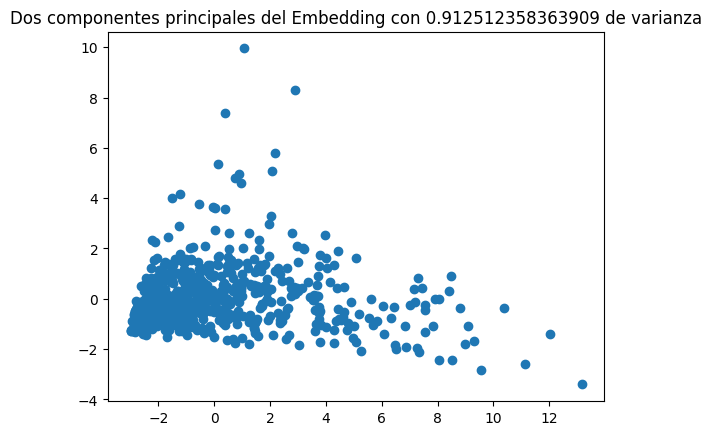

In [16]:
pca = PCA(n_components=2)
reduced_X = pca.fit_transform(features)
print(pca.explained_variance_ratio_)
plt.scatter(reduced_X[:,0],reduced_X[:,1])
plt.title(f"Dos componentes principales del Embedding con {np.sum(pca.explained_variance_ratio_)} de varianza")
plt.show()

In [17]:
pca = PCA(n_components=3)
reduced_X = pca.fit_transform(features)
print(pca.explained_variance_ratio_)

[0.75227506 0.1602373  0.037412  ]


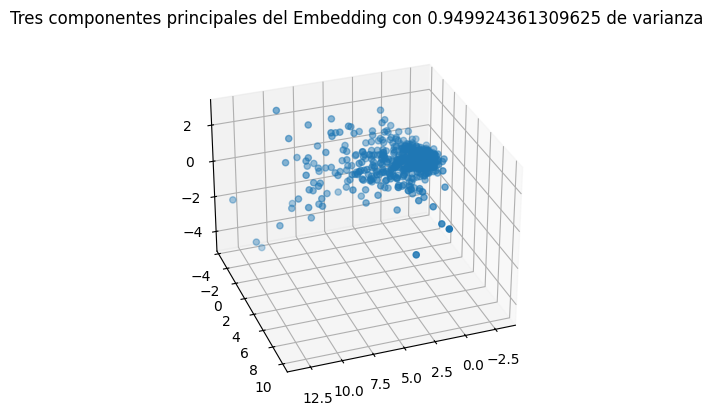

In [18]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(reduced_X[:,0], reduced_X[:,1], reduced_X[:,2])
ax.view_init(elev=30, azim=70, roll=0)
plt.title(f"Tres componentes principales del Embedding con {np.sum(pca.explained_variance_ratio_)} de varianza")
plt.show()

## Clasificación

##Gaussian Mixture Models (GMM)

Además de la representación visual, es posible aplicar modelos probabilísticos como los **Gaussian Mixture Models (GMM)** para analizar la distribución del espacio de características generado por BoVW. Estos modelos permiten capturar la **estructura multimodal** de los datos y realizar agrupamiento suave basado en probabilidades.


### ¿Qué es un Gaussian Mixture Model?

Un **GMM** modela la distribución de los datos como una combinación ponderada de varias **distribuciones normales multivariadas**:

$$
p(x) = \sum_{i=1}^{K} \pi_i \cdot \mathcal{N}(x \mid \mu_i, \Sigma_i)
$$

Donde:
- $\pi_i$ son los pesos (mezcla) de cada componente.
- $\mu_i$ y $\Sigma_i$ son la media y la covarianza de la $i$-ésima Gaussiana.
- $K$ es el número de componentes (clusters).

A diferencia de k-means, que asigna cada punto de forma dura a un clúster, GMM asigna **probabilidades de pertenencia** a cada componente.



Primera prueba del modelo

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, truth_labels, test_size=0.33, random_state=42)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_train)
y_pred = gmm.predict(X_test)

Evaluación del modelo

In [20]:
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       112
           1       0.73      0.66      0.69       113

    accuracy                           0.71       225
   macro avg       0.71      0.71      0.71       225
weighted avg       0.71      0.71      0.71       225



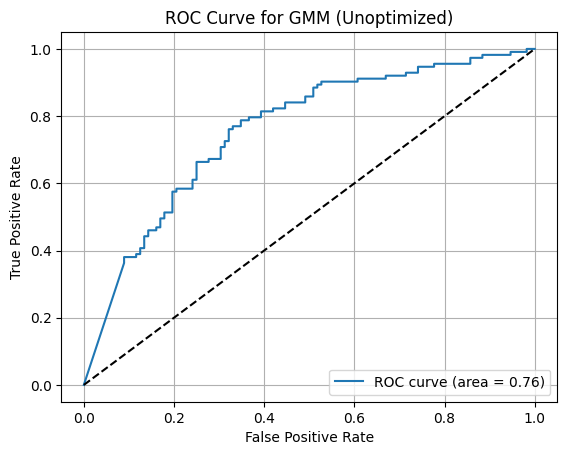

In [21]:
probs = gmm.predict_proba(X_test)
y_score = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GMM (Unoptimized)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Definimos una clase para realizar grid search y optimizar hiperparámetros del modelo de Gaussian Mixture

In [22]:
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, covariance_type='full', reg_covar=1e-6):
        self.covariance_type = covariance_type
        self.reg_covar = reg_covar
        self.n_components = 2

    def fit(self, X, y):
        self.gmm = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            random_state=42
        )
        self.gmm.fit(X)
        predicted = self.gmm.predict(X)

        return self

    def predict(self, X):
        preds = self.gmm.predict(X)
        return preds

f1_scorer = make_scorer(f1_score)
param_grid = {
    'covariance_type': ['spherical', 'tied', 'diag', 'full'],
    'reg_covar': [1e-6, 1e-4, 1e-2]
    #'init_params': ['kmeans', 'random'],
}

grid = GridSearchCV(GMMClassifier(), param_grid, scoring=f1_scorer, cv=3)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best f1_score:", grid.best_score_)

Best parameters: {'covariance_type': 'tied', 'reg_covar': 0.01}
Best f1_score: 0.5017771709441377


In [23]:
gm = GaussianMixture(n_components=2, random_state=42, **grid.best_params_)
gm.fit(X_train)
y_pred = gm.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.54      0.97      0.70       112
           1       0.88      0.19      0.31       113

    accuracy                           0.58       225
   macro avg       0.71      0.58      0.50       225
weighted avg       0.71      0.58      0.50       225



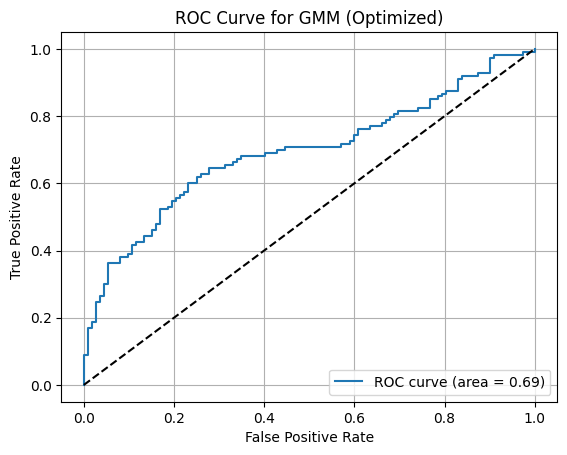

In [24]:
probs = gm.predict_proba(X_test)
y_score = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GMM (Optimized)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Dado que el grid search no encuentra el modelo óptimo, utilizaremos el primero que encontramos que tiene mejores parámetros y desempeño.

# Prueba del modelo con una imagen propia.


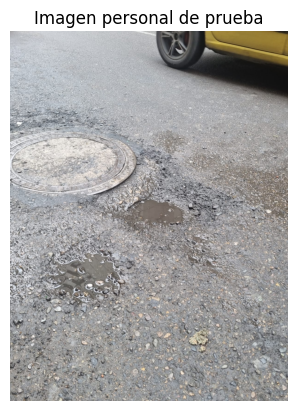

In [33]:
img1 = cv2.imread('test_propio.jpeg')
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.title("Imagen personal de prueba")
plt.axis("off")
plt.imshow(img1_rgb)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


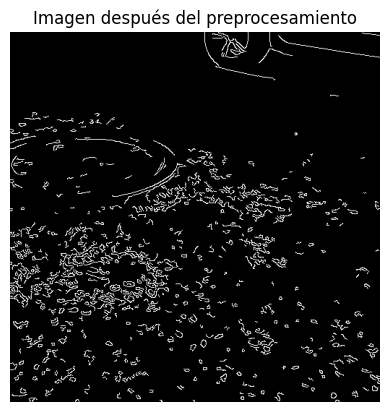

In [34]:
resultado = preprocesamiento.transform([img1])

plt.imshow(resultado[0], cmap='gray')
plt.title("Imagen después del preprocesamiento")
plt.axis('off')
plt.show()

In [35]:
features_test = detect_features.fit_transform(resultado)
label_test = gmm.predict(features_test)
print(f"La imágen de prueba fue clasificada como {label_test}")

La imágen de prueba fue clasificada como [1]


Esto muestra que el modelo clasifica correctamente la imágen nueva dado que la label de "1" corresponde a una imagen con hueco.